In [8]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.distributions import Beta
from collections import Counter

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
os.makedirs("checkpoints", exist_ok=True)

# -------------------- Upsampling --------------------
def upsample(X, y):
    classes = np.unique(y)
    counts = Counter(y)
    max_count = max(counts.values())
    
    X_resampled, y_resampled = [], []
    for cls in classes:
        idx = np.where(y == cls)[0]
        reps = max_count // len(idx)
        remainder = max_count % len(idx)
        idx_full = np.concatenate([np.tile(idx, reps), np.random.choice(idx, remainder, replace=False)])
        X_resampled.append(X[idx_full])
        y_resampled.append(y[idx_full])
    return np.vstack(X_resampled), np.concatenate(y_resampled)

# -------------------- Data Loader --------------------
def load_and_preprocess_data(path='input/ML_data.csv'):
    df = pd.read_csv(path).drop(columns=['Samples'])
    df = df[df['Cell_type'] != 'Unknown']
    le = LabelEncoder()
    df['Cell_type'] = le.fit_transform(df['Cell_type'])
    X = StandardScaler().fit_transform(df.drop(columns=['Cell_type']))
    y = df['Cell_type'].values

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Upsample training data
    X_train, y_train = upsample(X_train, y_train)

    train_loader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)),
        batch_size=64, shuffle=True
    )
    val_loader = DataLoader(TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.long)),
        batch_size=64, shuffle=False
    )
    return df, X, y, le, X.shape[1], len(le.classes_), train_loader, val_loader

# -------------------- Residual Block --------------------
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            utils.spectral_norm(nn.Linear(dim, dim)),
            nn.LayerNorm(dim),
            nn.GELU()
        )

    def forward(self, x):
        return x + self.block(x)


# -------------------- FiLM Layer --------------------
class FiLM(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gamma = nn.Linear(hidden_dim, hidden_dim)
        self.beta = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, time_emb, cond_emb):
        return cond_emb * self.gamma(time_emb) + self.beta(time_emb)

# -------------------- Model --------------------
import torch.nn.utils as utils

class MLPVectorField(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim=256, num_layers=6):
        super().__init__()
        self.embedding = nn.Embedding(cond_dim, hidden_dim)

        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.film_layer = FiLM(hidden_dim)

        layers = [
            nn.Sequential(
                utils.spectral_norm(nn.Linear(input_dim + 2 * hidden_dim, hidden_dim)),
                nn.SiLU()
            )
        ]

        for _ in range(num_layers - 2):
            layers.append(ResBlock(hidden_dim))

        layers.append(nn.Linear(hidden_dim, input_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, t, x, cond_idx):
        cond_emb = self.embedding(cond_idx)
        t_emb = self.time_emb(t)
        t_emb = self.film_layer(t_emb, cond_emb)
        x_cat = torch.cat([x, cond_emb, t_emb], dim=-1)
        return self.net(x_cat)


# -------------------- EMA --------------------
class EMAHelper:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {k: v.clone().detach() for k, v in model.state_dict().items()}

    def update(self):
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    self.shadow[name] = self.decay * self.shadow[name] + (1. - self.decay) * param.data

    def apply_shadow(self):
        self.backup = {k: v.clone() for k, v in self.model.state_dict().items()}
        self.model.load_state_dict(self.shadow)

    def restore(self):
        self.model.load_state_dict(self.backup)

# -------------------- Loss --------------------
def cfm_loss(model, x, cond_idx, beta_sampler=Beta(0.5, 0.5), weight_cosine=0.1):
    batch_size = x.size(0)
    t = beta_sampler.sample((batch_size, 1)).to(x.device)
    z = torch.randn_like(x)
    x_t = (1 - t) * z + t * x
    v_target = x - z
    v_pred = model(t, x_t, cond_idx)
    mse = F.mse_loss(v_pred, v_target)
    cosine = (1 - F.cosine_similarity(v_pred, v_target, dim=-1)).mean()
    return mse + weight_cosine * cosine

# -------------------- Main --------------------
df, X_scaled, y, le, input_dim, num_classes, train_loader, val_loader = load_and_preprocess_data()
n_epochs = 1000

model = MLPVectorField(input_dim=input_dim, cond_dim=num_classes).to(device)
ema_helper = EMAHelper(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= n_epochs, eta_min=1e-6)

#beta_dist = Beta(0.5, 0.5)
beta_dist = Beta(2, 2)


for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        loss = cfm_loss(model, x_batch, y_batch, beta_dist)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema_helper.update()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_loss += cfm_loss(model, x_val, y_val, beta_dist).item()
    val_loss /= len(val_loader)

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    scheduler.step(train_loss)
    print(f"Epoch [{epoch}/{n_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")


Using device: cuda
Epoch [1/1000] | Train Loss: 2.1683 | Val Loss: 2.0304 | LR: 0.000100


/home/thomas/miniconda3/envs/DeepN/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/1000] | Train Loss: 1.9049 | Val Loss: 2.0502 | LR: 0.000100
Epoch [3/1000] | Train Loss: 1.8339 | Val Loss: 1.9736 | LR: 0.000100
Epoch [4/1000] | Train Loss: 1.7588 | Val Loss: 1.9099 | LR: 0.000100
Epoch [5/1000] | Train Loss: 1.7189 | Val Loss: 1.9028 | LR: 0.000100
Epoch [6/1000] | Train Loss: 1.6715 | Val Loss: 1.8745 | LR: 0.000100
Epoch [7/1000] | Train Loss: 1.6425 | Val Loss: 1.8382 | LR: 0.000100
Epoch [8/1000] | Train Loss: 1.5967 | Val Loss: 1.8725 | LR: 0.000100
Epoch [9/1000] | Train Loss: 1.5743 | Val Loss: 1.8151 | LR: 0.000100
Epoch [10/1000] | Train Loss: 1.5509 | Val Loss: 1.8346 | LR: 0.000100
Epoch [11/1000] | Train Loss: 1.5470 | Val Loss: 1.8255 | LR: 0.000100
Epoch [12/1000] | Train Loss: 1.5265 | Val Loss: 1.8170 | LR: 0.000100
Epoch [13/1000] | Train Loss: 1.5058 | Val Loss: 1.8326 | LR: 0.000100
Epoch [14/1000] | Train Loss: 1.4773 | Val Loss: 1.7835 | LR: 0.000100
Epoch [15/1000] | Train Loss: 1.4503 | Val Loss: 1.7504 | LR: 0.000100
Epoch [16/1000

In [9]:
import torch
torch.save(model.state_dict(), "generated/cFM_model.pt")


# Save EMA model weights
ema_helper.apply_shadow()
torch.save(model.state_dict(), "checkpoints/model_ema.pth")
ema_helper.restore()  # Restore the original weights back to model after saving EMA

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------ Generation Function ------------------------

@torch.no_grad()
def generate_synthetic_data(model, label_encoder, num_samples_per_class=5000, steps=150, path='output/fake_data_FM.csv'):
    model.eval()
    all_synthetic, all_labels = [], []
    dt = 1.0 / steps
    num_classes = len(label_encoder.classes_)
    
    for class_idx in range(num_classes):
        z_t = torch.randn(num_samples_per_class, input_dim).to(device)
        class_batch = torch.full((num_samples_per_class,), class_idx, dtype=torch.long).to(device)

        for _ in range(steps):
            t = torch.rand(num_samples_per_class, 1).to(device)
            dz_dt = model(t, z_t, class_batch)
            z_t = z_t + dz_dt * dt  # Euler step

        all_synthetic.append(z_t.cpu().numpy())
        all_labels.extend([class_idx] * num_samples_per_class)

    X_fake = np.vstack(all_synthetic)
    y_fake = np.array(all_labels)
    df_fake = pd.DataFrame(X_fake, columns=[f'feature_{i}' for i in range(X_fake.shape[1])])
    df_fake['Cell_type'] = label_encoder.inverse_transform(y_fake)

    os.makedirs(os.path.dirname(path), exist_ok=True)
    df_fake.to_csv(path, index=False)
    print(f"[+] Generated and saved {len(X_fake)} samples to: {path}")
    return X_fake, y_fake

# ------------------------ Evaluation Functions ------------------------

def compute_mmd(real, fake, kernel="rbf", gamma=1.0):
    k_XX = rbf_kernel(real, real, gamma=gamma)
    k_YY = rbf_kernel(fake, fake, gamma=gamma)
    k_XY = rbf_kernel(real, fake, gamma=gamma)
    mmd = k_XX.mean() + k_YY.mean() - 2 * k_XY.mean()
    return mmd

def compute_avg_wasserstein(real, fake):
    return np.mean([
        wasserstein_distance(real[:, i], fake[:, i])
        for i in range(real.shape[1])
    ])

# ------------------------ Main Execution ------------------------

# Generate
X_fake, y_fake = generate_synthetic_data(model, le)

# Per-class evaluation
num_classes = len(le.classes_)
real_per_class = [X_scaled[y == i] for i in range(num_classes)]
fake_per_class = [X_fake[y_fake == i] for i in range(num_classes)]

for i, (real, fake) in enumerate(zip(real_per_class, fake_per_class)):
    print(f"\nClass {i} ({le.inverse_transform([i])[0]}):")
    print("MMD:", compute_mmd(real, fake))
    print("Wasserstein:", compute_avg_wasserstein(real, fake))


TypeError: generate_synthetic_data() missing 2 required positional arguments: 'input_dim' and 'device'

In [23]:
# ------------------------ Downsampling Function ------------------------

import pandas as pd
import numpy as np
from sklearn.utils import resample
import os

def downsample_synthetic_data(input_path, output_path, target_total=800):
    df = pd.read_csv(input_path)
    if 'Cell_type' not in df.columns:
        raise ValueError("Expected a 'Cell_type' column in input CSV.")

    class_counts = df['Cell_type'].value_counts()
    total = class_counts.sum()
    class_proportions = class_counts / total

    resampled_frames = []
    for cell_type, prop in class_proportions.items():
        class_data = df[df['Cell_type'] == cell_type]
        n_samples = int(round(prop * target_total))
        replace = len(class_data) < n_samples
        sampled = resample(class_data, n_samples=n_samples, random_state=42, replace=replace)
        resampled_frames.append(sampled)

    df_downsampled = pd.concat(resampled_frames).sample(frac=1.0, random_state=42).reset_index(drop=True)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_downsampled.to_csv(output_path, index=False)

    print(f"[+] Downsampled to {target_total} total samples and saved to: {output_path}")
    print("Class Distribution After Downsampling:")
    print(df_downsampled['Cell_type'].value_counts())

    return df_downsampled

_ = downsample_synthetic_data(
    input_path='output/fake_data_FM.csv',
    output_path='output/fake_data_FM_downsampled.csv',
    target_total=800
)


[+] Downsampled to 800 total samples and saved to: output/fake_data_FM_downsampled.csv
Class Distribution After Downsampling:
Cell_type
T       200
B       200
PreT    200
PreB    200
Name: count, dtype: int64


[+] Downsampled to 1000 total samples and saved to: output/fake_data_FM_downsampled.csv
Class Distribution After Downsampling:
Cell_type
PreB    362
T       227
PreT    208
B       203
Name: count, dtype: int64


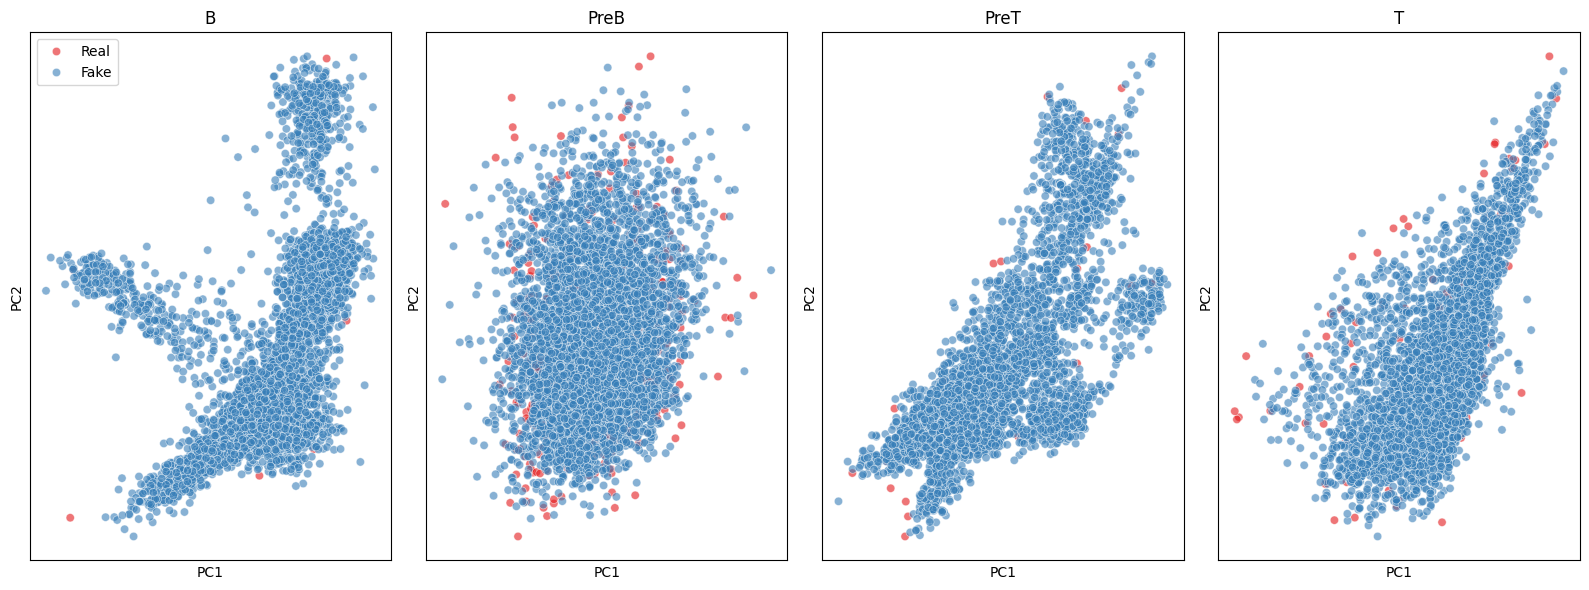

In [24]:
# ------------------------ PCA Plot Function ------------------------

def pca_real_vs_fake(real_X, real_y, fake_X, fake_y, label_encoder, n_components=2):
    pca = PCA(n_components=n_components)
    all_X = np.vstack([real_X, fake_X])
    all_pca = pca.fit_transform(all_X)
    
    real_pca = all_pca[:len(real_X)]
    fake_pca = all_pca[len(real_X):]

    real_df = pd.DataFrame(real_pca, columns=['PC1', 'PC2'])
    real_df['Source'] = 'Real'
    real_df['Cell_type'] = label_encoder.inverse_transform(real_y)

    fake_df = pd.DataFrame(fake_pca, columns=['PC1', 'PC2'])
    fake_df['Source'] = 'Fake'
    fake_df['Cell_type'] = label_encoder.inverse_transform(fake_y)

    df_combined = pd.concat([real_df, fake_df])

    plt.figure(figsize=(16, 6))
    for i, class_name in enumerate(label_encoder.classes_):
        plt.subplot(1, len(label_encoder.classes_), i + 1)
        sns.scatterplot(data=df_combined[df_combined['Cell_type'] == class_name],
                        x='PC1', y='PC2', hue='Source', alpha=0.6, palette='Set1')
        plt.title(class_name)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.legend()
        else:
            plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()

# PCA Plot
pca_real_vs_fake(X_scaled, y, X_fake, y_fake, le)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import os

def downsample_synthetic_data_with_metrics(input_path, output_path, metrics, target_total=800, alpha=0.5):
    """
    Downsamples synthetic data with weighting based on both real class proportions and quality metrics.

    Parameters:
        input_path (str): Path to the CSV with synthetic data.
        output_path (str): Path to save the downsampled data.
        metrics (dict): Dictionary of quality scores (e.g., {'B': 0.1, 'PreB': 0.01, ...}).
                        Lower = better quality. Usually MMD or Wasserstein.
        target_total (int): Target number of samples after downsampling.
        alpha (float): Blend factor between class proportion (alpha) and inverse quality (1 - alpha).
                       Set alpha=1.0 for pure proportion-based sampling.
    """
    df = pd.read_csv(input_path)
    if 'Cell_type' not in df.columns:
        raise ValueError("Expected a 'Cell_type' column in input CSV.")

    # Step 1: Calculate real proportions
    class_counts = df['Cell_type'].value_counts()
    class_proportions = class_counts / class_counts.sum()

    # Step 2: Convert metrics to weights (lower score → higher weight)
    inverse_scores = {k: 1.0 / (v + 1e-8) for k, v in metrics.items()}
    total_weight = sum(inverse_scores.values())
    metric_weights = {k: v / total_weight for k, v in inverse_scores.items()}

    # Step 3: Combine proportion and metric weights
    blended_weights = {
        k: alpha * class_proportions.get(k, 0) + (1 - alpha) * metric_weights.get(k, 0)
        for k in class_proportions.index
    }

    # Step 4: Resample each class
    resampled_frames = []
    for cell_type, weight in blended_weights.items():
        class_data = df[df['Cell_type'] == cell_type]
        n_samples = int(round(weight * target_total))
        replace = len(class_data) < n_samples
        sampled = resample(class_data, n_samples=n_samples, random_state=42, replace=replace)
        resampled_frames.append(sampled)

    # Step 5: Combine and save
    df_downsampled = pd.concat(resampled_frames).sample(frac=1.0, random_state=42).reset_index(drop=True)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_downsampled.to_csv(output_path, index=False)

    print(f"[+] Downsampled to {target_total} total samples and saved to: {output_path}")
    print("Class Distribution After Downsampling:")
    print(df_downsampled['Cell_type'].value_counts())

    return df_downsampled

# Example MMDs (lower = better)
metrics = {
    'B': 0.094,
    'PreB': 0.0018,
    'PreT': 0.0387,
    'T': 0.0108380
}

df_downsampled = downsample_synthetic_data_with_metrics(
    input_path='output/fake_data_FM.csv',
    output_path='output/fake_data_FM_downsampled.csv',
    metrics=metrics,
    target_total=1000,
    alpha=0.8  # 70% based on class size, 30% based on quality
)


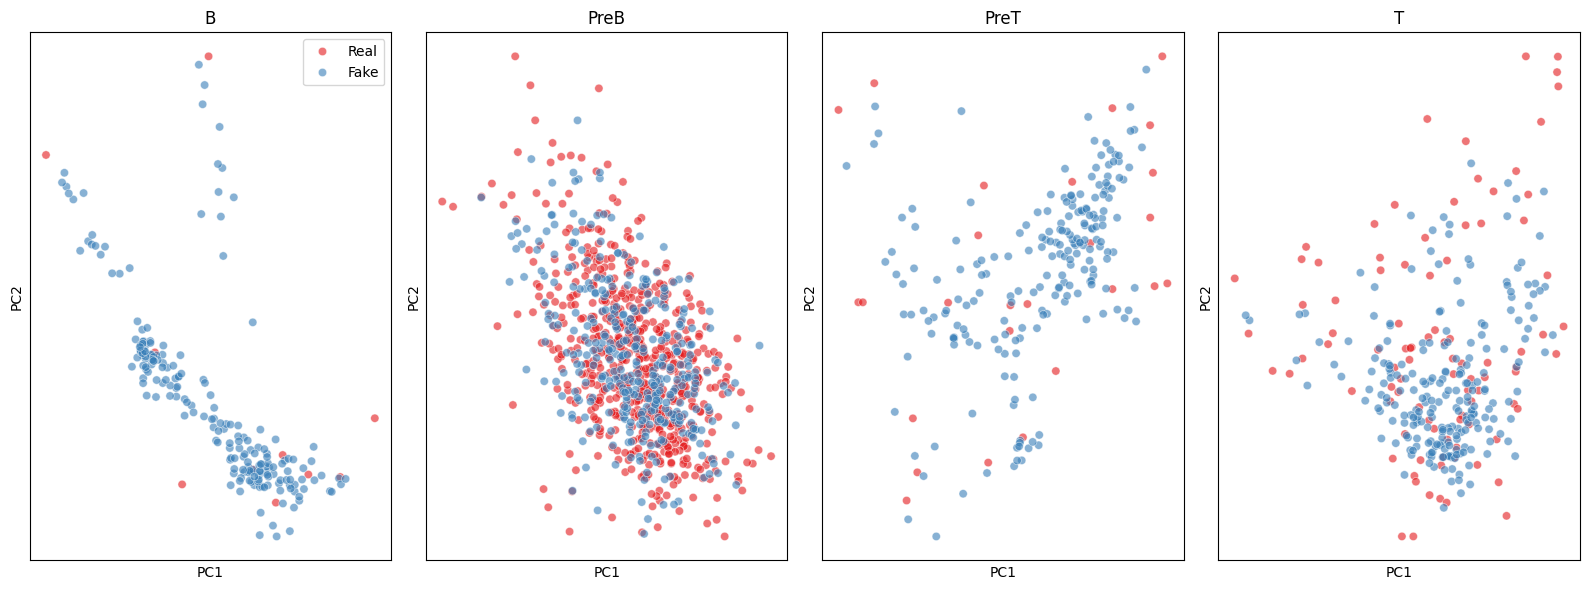

In [32]:
# ------------------------ PCA Plot Function (From Downsampled DF) ------------------------

def pca_from_df_downsampled(real_X, real_y, fake_df, label_encoder, n_components=2):
    # Prepare data
    fake_X = fake_df.drop(columns=['Cell_type']).values
    fake_y = label_encoder.transform(fake_df['Cell_type'].values)

    # Run PCA on joint space
    pca = PCA(n_components=n_components)
    all_X = np.vstack([real_X, fake_X])
    all_pca = pca.fit_transform(all_X)

    real_pca = all_pca[:len(real_X)]
    fake_pca = all_pca[len(real_X):]

    # Build labeled DataFrames
    real_df = pd.DataFrame(real_pca, columns=['PC1', 'PC2'])
    real_df['Source'] = 'Real'
    real_df['Cell_type'] = label_encoder.inverse_transform(real_y)

    fake_df_plot = pd.DataFrame(fake_pca, columns=['PC1', 'PC2'])
    fake_df_plot['Source'] = 'Fake'
    fake_df_plot['Cell_type'] = label_encoder.inverse_transform(fake_y)

    df_combined = pd.concat([real_df, fake_df_plot])

    # Plot
    plt.figure(figsize=(16, 6))
    for i, class_name in enumerate(label_encoder.classes_):
        plt.subplot(1, len(label_encoder.classes_), i + 1)
        sns.scatterplot(data=df_combined[df_combined['Cell_type'] == class_name],
                        x='PC1', y='PC2', hue='Source', alpha=0.6, palette='Set1')
        plt.title(class_name)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.legend()
        else:
            plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()


# PCA plot from df_downsampled
pca_from_df_downsampled(X_scaled, y, df_downsampled, le)
